# MNIST Digits - Classification Using SVM

In this notebook, we'll explore the popular MNIST dataset and build an SVM model to classify handwritten digits. <a href='http://yann.lecun.com/exdb/mnist/'>Here is a detailed description of the dataset.</a>

This is a part of a kaggle competition - https://www.kaggle.com/c/digit-recognizer.

# Objective
We will develop a model using Support Vector Machine which should correctly classify the handwritten digits from 0-9 based on the pixel values given as features. Thus, this is a 10-class classification problem. 

# Data Description
For this problem, we use the MNIST data which is a large database of handwritten digits. The 'pixel values' of each digit (image) comprise the features, and the actual number between 0-9 is the label. 

 

Since each image is of 28 x 28 pixels, and each pixel forms a feature, there are 784 features. MNIST digit recognition is a well-studied problem in the ML community, and people have trained numerous models (Neural Networks, SVMs, boosted trees etc.) achieving error rates as low as 0.23% (i.e. accuracy = 99.77%, with a convolutional neural network).

 

Before the popularity of neural networks, though, models such as SVMs and boosted trees were the state-of-the-art in such problems.

We'll first explore the dataset a bit, prepare it (scale etc.) and then experiment with linear and non-linear SVMs with various hyperparameters.<br>

----------
We'll divide the analysis into the following parts:
- Data understanding and cleaning
- Data preparation for model building
- Building an SVM model - hyperparameter tuning, model evaluation etc.

#### NOTE:
Considering the **computational limitations** of the system and the data size at hand, to make our life easier we are going to use 50% of the available data set for model building.<br>

Final model can be extended to operate on the complete data set as well, considering appropirate computatinal power is available by the computing machine.


## Data Understanding and Cleaning
 
 Let's understand the dataset and see if it needs some cleaning etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import gc
import os
os.sys.path
!pip install opencv-python
import cv2

In [2]:
# read the dataset
digits = pd.read_csv("train.csv")
digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


In [3]:
# head
digits.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
four = digits.iloc[3, 1:]
four.shape

(784,)

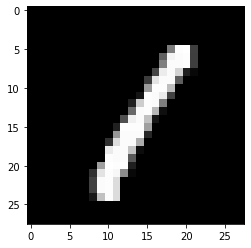

In [5]:
four = four.values.reshape(28, 28)
plt.imshow(four, cmap='gray')

#### Side note: Indexing Recall ####
`list =    [0, 4, 2, 10, 22, 101, 10]` <br>
`indices = [0, 1, 2, 3, ...,        ]` <br>
`reverse = [-n           -3  -2   -1]` <br>

In [6]:
# visualise the array
print(four[5:-5, 5:-5])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0 124 253 255  63   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  96 244 251 253  62   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 127 251 251 253  62   0]
 [  0   0   0   0   0   0   0   0   0   0   0  68 236 251 211  31   8   0]
 [  0   0   0   0   0   0   0   0   0   0  60 228 251 251  94   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 155 253 253 189   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  20 253 251 235  66   0   0   0   0]
 [  0   0   0   0   0   0   0   0  32 205 253 251 126   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 104 251 253 184  15   0   0   0   0   0]
 [  0   0   0   0   0   0   0  80 240 251 193  23   0   0   0   0   0   0]
 [  0   0   0   0   0   0  32 253 253 253 159   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 151 251 251 251  39   0   0   0   0   0   0   0]
 [  0   0   0   0   0  48 221 251 251 172   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 234

In [7]:
# Summarise the counts of 'label' to see how many labels of each digit are present
digits.label.value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: label, dtype: int64

In [8]:
# Summarise count in terms of percentage 
100*(round(digits.label.astype('category').value_counts()/len(digits.index), 4))

1    11.24
7    10.44
3    10.22
2     9.93
9     9.92
0     9.87
6     9.86
8     9.75
4     9.74
5     9.04
Name: label, dtype: float64

Thus, each digit/label has an approximately 9%-11% fraction in the dataset and the **dataset is balanced**. This is an important factor in considering the choices of models to be used, especially SVM, since **SVMs rarely perform well on imbalanced data** (think about why that might be the case).

Let's quickly look at missing values, if any.

In [9]:
# missing values - there are none
digits.isnull().sum()

label    0
1x1      0
1x2      0
1x3      0
1x4      0
        ..
28x24    0
28x25    0
28x26    0
28x27    0
28x28    0
Length: 785, dtype: int64

Also, let's look at the average values of each column, since we'll need to do some rescaling in case the ranges vary too much.

In [10]:
# average values/distributions of features
description = digits.describe()
description

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
count,60000.000000,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0000,60000.0,60000.0,60000.0,60000.0
mean,4.453933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200433,0.088867,0.045633,0.019283,0.015117,0.0020,0.0,0.0,0.0,0.0
std,2.889270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.042472,3.956189,2.839845,1.686770,1.678283,0.3466,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.0000,0.0,0.0,0.0,0.0


In [11]:
digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


You can see that the max value of the mean and maximum values of some features (pixels) is 139, 255 etc., whereas most features lie in much lower ranges  (look at description of pixel 0, pixel 1 etc. above).

Thus, it seems like a good idea to rescale the features.

## Data Preparation for Model Building

Let's now prepare the dataset for building the model. We'll only use a fraction of the data else training will take a long time.


In [12]:
# Creating training and test sets
# Splitting the data into train and test
X = digits.iloc[:, 1:]
Y = digits.iloc[:, 0]

# Rescaling the features
from sklearn.preprocessing import scale
X = scale(X)

# train test split with train_size=10% and test size=90%
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.10, random_state=101)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(6000, 784)
(54000, 784)
(6000,)
(54000,)


In [13]:
# delete test set from memory, to avoid a memory error
# we'll anyway use CV to evaluate the model, and can use the separate test.csv file as well
# to evaluate the model finally

# del x_test
# del y_test

## Model Building

Let's now build the model and tune the hyperparameters. Let's start with a **linear model** first.

### Linear SVM

Let's first try building a linear SVM model (i.e. a linear kernel). 

In [14]:
from sklearn import svm
from sklearn import metrics

# an initial SVM model with linear kernel   
svm_linear = svm.SVC(kernel='linear')

# fit
svm_linear.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [15]:
# predict
predictions = svm_linear.predict(x_test)
predictions[:10]

array([7, 4, 9, 6, 1, 1, 8, 0, 3, 2], dtype=int64)

In [16]:
# evaluation: accuracy
# C(i, j) represents the number of points known to be in class i 
# but predicted to be in class j
confusion = metrics.confusion_matrix(y_true = y_test, y_pred = predictions)
confusion

array([[5165,    4,   38,   12,   15,   29,   50,    5,   17,    0],
       [   1, 5946,   22,   12,    7,    8,    4,   11,   24,   12],
       [  71,   67, 4880,   84,   61,   15,   54,   47,   62,   11],
       [  43,   57,  184, 4770,   13,  230,    8,   43,  120,   46],
       [  21,   26,   64,   10, 4824,    8,   23,   19,   14,  257],
       [  82,   56,   54,  244,   63, 4141,   82,   10,  105,   38],
       [  54,   19,   65,    5,   38,   69, 5062,    3,   15,    1],
       [  13,   54,   90,   40,  120,    6,    1, 5130,   11,  194],
       [  44,  176,  104,  192,   34,  190,   42,   29, 4417,   36],
       [  27,   22,   37,   67,  200,   26,    2,  185,   41, 4750]],
      dtype=int64)

In [17]:
# measure accuracy
metrics.accuracy_score(y_true=y_test, y_pred=predictions)

0.9089814814814815

In [18]:
# class-wise accuracy
class_wise = metrics.classification_report(y_true=y_test, y_pred=predictions)
print(class_wise)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      5335
           1       0.93      0.98      0.95      6047
           2       0.88      0.91      0.90      5352
           3       0.88      0.87      0.87      5514
           4       0.90      0.92      0.91      5266
           5       0.88      0.85      0.86      4875
           6       0.95      0.95      0.95      5331
           7       0.94      0.91      0.92      5659
           8       0.92      0.84      0.88      5264
           9       0.89      0.89      0.89      5357

    accuracy                           0.91     54000
   macro avg       0.91      0.91      0.91     54000
weighted avg       0.91      0.91      0.91     54000



In [19]:
# run gc.collect() (garbage collect) to free up memory
# else, since the dataset is large and SVM is computationally heavy,
# it'll throw a memory error while training
gc.collect()

20

### Non-Linear SVM

Let's now try a non-linear model with the RBF kernel.

In [20]:
# rbf kernel with other hyperparameters kept to default 
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(x_train, y_train)

C:\Users\MODY2\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [22]:
# predict
predictions = svm_rbf.predict(x_test)

# accuracy 
print(metrics.accuracy_score(y_true=y_test, y_pred=predictions))

0.9281666666666667


The accuracy achieved with a non-linear kernel is slightly higher than a linear one. Let's now do a grid search CV to tune the hyperparameters C and gamma.

